## LSST Solar System Processing

## Linking of Simulated dataset with HelioLinC3D

### Algorithm: 

* Similar to HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
* The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
* A tracklet + velocity vector is called an "arrow". 
* Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.
* We calculate a mean state and variance for each cluster (trimmed mean), which is our best guess for the underlying orbit (IOD)
* We can filter all clusters based on their variance

### Implementation:
S. Eggl 20210218
    

In [1]:
# HelioLinC3D Solar System Processing functions for LSST
import heliolinc2 as hl

In [2]:
# Did I Find It Analysis tool (Moeyens et al.)
import difi

In [3]:
from difi import __version__
print("difi version: {}".format(__version__))

difi version: 1.1.dev56+geb5cfa7


In [41]:
# Demo relevant python modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
# Joblib prallelization
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [6]:
# Progress bar for joblib processes
import contextlib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

## SIMULATED OBSERVATIONS 


### Select observations from LSST Survey Simulation Dataset

Cornwall et al. 2020, 5deg x 5deg, 14 nights 

In [7]:
data_dir='../../jpl_survey_sim/s3c'
# S3M Main Belt Asteroids (MBA)
fnobservations1='S1_01.dat.csv'
# S3M Near-Earth Objects (NEO)
fnobservations0='S0.dat.csv'

In [8]:
dfin0= pd.read_csv(os.path.join(data_dir, fnobservations0),nrows=240000, sep=',').dropna()
dfin1= pd.read_csv(os.path.join(data_dir, fnobservations1),nrows=240000, sep=',').dropna()

In [9]:
# combine datasets
dfin=pd.concat([dfin0,dfin1])
# re-index new dataset 
dfin.reset_index(drop=True,inplace=True);
# preserve observation identifier as string
dfin['obsName']=dfin.index.astype(str);

Select subset RA [310, 315] deg, Dec [-10, -5] deg, 16 nights 

In [10]:
dfin_sel = hl.selectObservationSubset(dfin, RAmin=310, RAmax=315, DECmin=-10, DECmax=-5,
                            timemin=dfin['FieldMJD'].min(),timemax=dfin['FieldMJD'].min()+16,
                            RAName='AstRA(deg)',DECName='AstDec(deg)',timeName='FieldMJD')

In [11]:
dfin_sel

ObjID  observationId      FieldMJD  AstRange(km)  \
0     S0000x8Ka           6960  59862.991269  3.047683e+07   
1     S0000VCJa           8622  59864.991848  3.232372e+07   
2     S00003Gda           8807  59865.078950  1.210860e+08   
3     S0000VCJa           8808  59865.079398  3.230906e+07   
4     S000026Ea           8808  59865.079398  6.389611e+07   
...         ...            ...           ...           ...   
4177  S1008PPua           5430  59861.070844  3.736241e+08   
4178  S1008PVua           5430  59861.070844  3.265713e+08   
4179  S100e0wSa           5430  59861.070844  3.604591e+08   
4180  S1009pbIa           5430  59861.070844  1.864861e+08   
4181  S1007cwTa           5430  59861.070844  4.804149e+08   

      AstRangeRate(km/s)  AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  \
0                 -6.554  310.580792           -0.581848    -8.573453   
1                 -2.050  312.799644           -0.739545    -6.479219   
2                 24.493  310.130263            0.329577    -9.551818   
3                 -1.831  312.735079           -0.732300    -6.437058   
4                 12.369  310.837913            1.404100    -7.623651   
...                  ...         ...                 ...          ...   
4177              21.542  314.322668            0.045551    -9.440291   
4178              22.848  313.289684            0.076316    -9.966770   
4179              21.341  312.689186            0.043518    -9.986396   
4180              15.219  313.400486            0.160532    -9.540816   
4181              24.036  312.773964            0.017436    -9.653992   

      AstDecRate(deg/day)  Ast-Sun(J2000x)(km)  ...  Ast-Sun(J2000z)(km)  \
0                0.612289         1.621865e+08  ...         1.315995e+07   
1                0.479283         1.627026e+08  ...         1.599120e+07   
2                0.378337         2.177661e+08  ...        -3.704957e+05   
3                0.483769         1.625914e+08  ...         1.610066e+07   
4                0.094872         1.822181e+08  ...         1.124607e+07   
...                   ...                  ...  ...                  ...   
4177            -0.060441         4.015738e+08  ...        -4.545587e+07   
4178            -0.001540         3.646050e+08  ...        -4.069613e+07   
4179            -0.030174         3.847545e+08  ...        -4.668294e+07   
4180             0.078027         2.704196e+08  ...        -1.508425e+07   
4181            -0.061329         4.656918e+08  ...        -6.473869e+07   

      Sun-Ast-Obs(deg)       V  Filtermag  V(H=0)  Filter AstRASigma(mas)  \
0            57.117245  22.846     22.591  -1.195       r       28.438144   
1            56.017491  23.644     23.389  -1.083       r      126.781273   
2            38.975121  23.270     23.015   1.956       r       70.192415   
3            56.146488  23.646     23.391  -1.081       r      126.363744   
4            49.565702  21.056     20.801   0.434       r       16.459057   
...                ...     ...        ...     ...     ...             ...   
4177         16.484731  22.308     22.010   5.328       z       45.072011   
4178         18.598020  21.994     21.593   4.874       z       31.887052   
4179         17.353959  21.494     21.093   5.204       z       21.912966   
4180         27.456862  19.135     18.837   3.125       z       10.510478   
4181         13.687560  21.641     21.343   6.201       z       26.251020   

      AstDecSigma(mas)  PhotometricSigma(mag)  obsName  
0            28.438144               0.058672     4070  
1           126.781273               0.174340     5647  
2            70.192415               0.114590     6130  
3           126.363744               0.181180     6131  
4            16.459057               0.020272     6132  
...                ...                    ...      ...  
4177         45.072011               0.102971   473154  
4178         31.887052               0.071975   473155  
4179         21.912966               

In [12]:
# convert observations to HelioLinC ingestible format
import warnings
warnings.filterwarnings('ignore')
dfobs=hl.obs2heliolinc(dfin_sel,uniqueObsId=True, uniqueObsIdName="obsName");

In [13]:
dfobs

index          time          RA       DEC  obsId obsName  night  \
0         0  59862.991269  310.580792 -8.573453      0    4070      9   
1         1  59864.991848  312.799644 -6.479219      1    5647     11   
2         2  59865.078950  310.130263 -9.551818      2    6130     11   
3         3  59865.079398  312.735079 -6.437058      3    6131     11   
4         4  59865.079398  310.837913 -7.623651      4    6132     11   
...     ...           ...         ...       ...    ...     ...    ...   
4177   4177  59861.070844  314.322668 -9.440291   4177  473154      7   
4178   4178  59861.070844  313.289684 -9.966770   4178  473155      7   
4179   4179  59861.070844  312.689186 -9.986396   4179  473156      7   
4180   4180  59861.070844  313.400486 -9.540816   4180  473161      7   
4181   4181  59861.070844  312.773964 -9.653992   4181  473171      7   

         x_obs     y_obs     z_obs    vx_obs    vy_obs    vz_obs  
0     0.953108  0.297552 -0.000027 -0.005214  0.016474 -0.000055  
1     0.941735  0.330083 -0.000031 -0.005781  0.016295 -0.000058  
2     0.941227  0.331506 -0.000037 -0.005906  0.016357 -0.000088  
3     0.941224  0.331513 -0.000037 -0.005906  0.016357 -0.000088  
4     0.941224  0.331513 -0.000037 -0.005906  0.016357 -0.000088  
...        ...       ...       ...       ...       ...       ...  
4177  0.962976  0.266007 -0.000030 -0.004751  0.016699 -0.000083  
4178  0.962976  0.266007 -0.000030 -0.004751  0.016699 -0.000083  
4179  0.962976  0.266007 -0.000030 -0.004751  0.016699 -0.000083  
4180  0.962976  0.266007 -0.000030 -0.004751  0.016699 -0.000083  
4181  0.962976  0.266007 -0.000030 -0.004751  0.016699 -0.000083  

[4182 rows x 13 columns]

### Analyze LSST Field

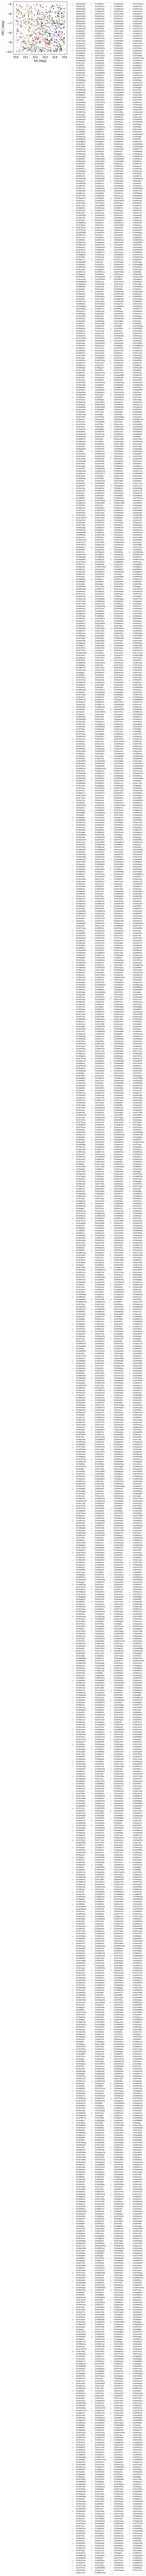

In [14]:
hl.plot.plotField(dfin_sel,objName='ObjID',raName='AstRA(deg)',decName='AstDec(deg)')

### Since we are looking at a fraction of the sky, how many nights do we actually observe?

In [15]:
df_grouped_by_night=dfobs.groupby('night')

In [16]:
len(df_grouped_by_night.groups)

6

In [17]:
df_grouped_by_night.groups.keys()

dict_keys([0, 1, 6, 7, 9, 11])

## Run HelioLinC3D

### Choose HelioLinC3D clustering parameters

In [18]:
# Clustering radius for heliocentric positions projected from observations [au]
cr_obs=0.016
# Clustering radius for propagated arrows [au]
cr_arrows=0.02
# max temporal separation for tracklet observations (days)
ct_max=1.5/24
# min temporal separation for tracklet observations, e.g. exposure time (days)
ct_min=25/86400 
# Minimum number of arrows to be clustered ('DBSCAN only')
min_samples=3

### Choose heliocentric distance and velocity grid

In [19]:
# define range of heliocentric distances
rall=np.arange(1.8,3.3,0.1)

# define range of heliocentric radial velocities
drdtall=np.arange(-0.01,0.0151,0.002)
np.append(drdtall,0.0)

# Iterator for joblib based paralellization
rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

# How many configuraitons do we have to run?
print(len(rrdot))

195


In [20]:
# Parallelize over a grid of initial conditions

n_cores=10

with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 



HelioLinC2: 100%|██████████| 195/195 [01:50<00:00,  1.76it/s]


## Resulting Linkages

In [21]:
# each set of initial conditions produces a data frame with linkages; we merge all of them and give them a unique index
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
clustered_observations['clusterId']=clustered_observations.index

In [22]:
# Number of clusters respresenting potential objects 
len(clustered_observations)

717924

In [23]:
# deduplicate clusters with the same observations
dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
dedupe['cluster_Id']=dedupe.index

In [24]:
dedupe.head()

clusterId                                              obsId    r   drdt  \
0     149123  [4, 8, 1856, 1925, 1944, 1951, 1970, 1971, 197...  1.9  0.000   
1     240094  [4, 8, 1856, 1970, 1971, 1977, 2314, 2315, 234...  2.0  0.000   
2      49421  [4, 8, 1856, 1977, 2001, 2313, 2319, 2356, 236...  1.8  0.000   
3     314678         [4, 8, 1970, 1971, 2314, 2315, 2839, 3130]  2.1  0.000   
4     520293                           [4, 8, 2357, 2731, 2824]  2.5  0.002   

   cluster_epoch     x_ecl     y_ecl     z_ecl    vx_ecl    vy_ecl    vz_ecl  \
0   59859.547428  1.696844 -0.851146  0.252581  0.169658  0.454361 -0.086316   
1   59859.547428  1.764480 -0.930367  0.283079  0.180661  0.446628 -0.083859   
2   59859.547428  1.631367 -0.760766  0.244202  0.151522  0.455648 -0.078171   
3   59859.547428  1.824002 -1.027129  0.310727  0.199021  0.456716 -0.084942   
4   59859.547428  2.067854 -1.399451  0.395160  0.241713  0.489155 -0.100156   

    var_pos   var_vel  cluster_Id  
0  0.000375  0.009853           0  
1  0.000118  0.025035           1  
2  0.000291  0.019387           2  
3  0.000100  0.048858           3  
4  0.000080  0.148242           4

In [25]:
# Number of clusters respresenting potential objects after deduplication
len(dedupe)

56663

## Run DIFI

In [26]:
# DIFI compares clusters and objects that were linked through HelioLinC3D to the best case scenario.
dfdifi=hl.linkages2difi(dedupe,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

(all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, dedupe, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")



In [27]:
summary_heliolinc

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All          548     4182     98.604651       215    324             212   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0                3                 112                  221  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                   77   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                          77                                      72   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                       519                  5848   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           1266                      952   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                  204                 841967  

[1 rows x 31 columns]

In [28]:
# The number of clusters containing potential objects is still high wrt to the number of actual objects in the data. 
len(dedupe)

56663

## Mean State Filtering

In [32]:
# Filtering clusters with respect to their internal dispersion will select the best candidates for objects
variance_limit=1e-8
msf=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
msf['cluster_Id']=msf.index

In [33]:
# number of resulting clusters
len(msf)

726

In [34]:
dfdifi=hl.linkages2difi(msf,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

(all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, msf, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")

In [35]:
# Now we have roughly as many clusters as there are objects to be discovered. However, the completenss took a hit.
summary_heliolinc

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All          548     4182     89.302326       215    276             192   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0               23                  84                  249  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                    0   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                           0                                       0   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                         2                  4472   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                            579                        0   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                    0                      4  

[1 rows x 31 columns]

### Run HelioLinC3D for different clustering parameters


In [36]:
# How do completeness and purity change with varying clustering parameters?
cr_arrow_range=np.arange(0.006,0.016,0.001)

In [37]:
cr_arrow_range

array([0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014,
       0.015])

In [38]:
cr_arrow_range=np.arange(0.006,0.016,0.001)

results=[]

for cr_arrows in cr_arrow_range:
    # Clustering radius for heliocentric positions projected from observations [au]
    cr_obs=0.06
    # Clustering radius for propagated arrows [au]
    #cr_arrows=0.012
    # max temporal separation for tracklet observations (days)
    ct_max=1.5/24
    # min temporal separation for tracklet observations, e.g. exposure time (days)
    ct_min=25/86400 
    # Minimum number of arrows to be clustered ('DBSCAN only')
    min_samples=3


    # define range of heliocentric distances
    rall=np.arange(1.8,3.3,0.1)

    # define range of heliocentric radial velocities
    drdtall=np.arange(-0.01,0.0151,0.001)
    np.append(drdtall,0.0)

    # Iterator for joblib based paralellization
    rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

    # How many configuraitons do we have to run?
    print(len(rrdot))


    n_cores=10

    with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 

    clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
    clustered_observations['clusterId']=clustered_observations.index

    dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
    dedupe['cluster_Id']=dedupe.index

    dfdifi=hl.linkages2difi(dedupe,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
    dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
    dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

    (all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, dedupe, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")

    results.append([cr_arrows,all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects])

HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2: 100%|██████████| 390/390 [08:03<00:00,  1.24s/it]


## Study ROC curve before filtering

In [42]:
# monitor completeness numbers as function of clustering parameter
for r in results:
    print(r[0],r[6].completeness[0])

0.006 88.37209302325581
0.007 89.30232558139535
0.008 92.55813953488372
0.009000000000000001 94.4186046511628
0.01 94.88372093023256
0.011 95.81395348837209
0.012 97.20930232558139
0.013000000000000001 97.20930232558139
0.014 97.20930232558139
0.015000000000000001 97.67441860465117


In [43]:
# generate ROC data 
roc=[]
for r in results:
    roc.append([r[0],r[6].completeness[0],r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id)])
roc=np.array(roc)    

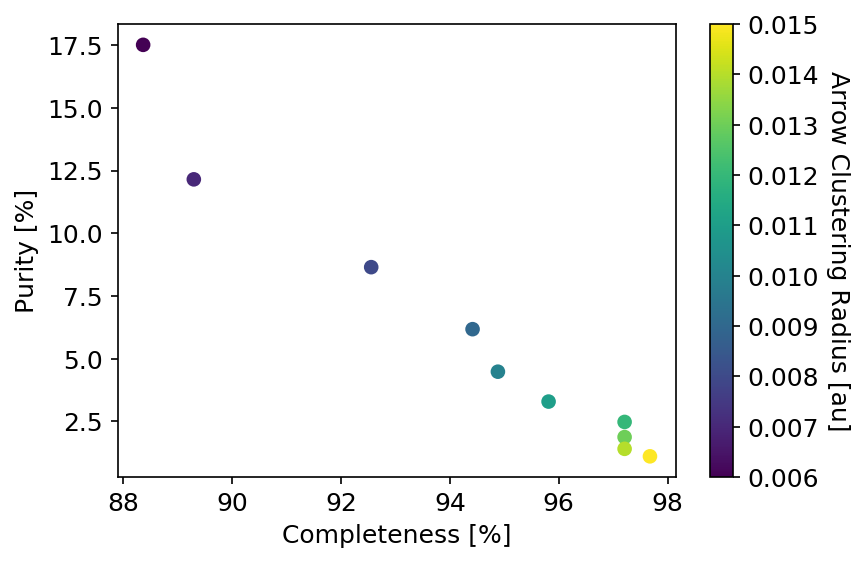

In [44]:
# plot ROC curve
plt.figure(dpi=150)
plt.scatter(roc[:,1],roc[:,2],c=roc[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Purity [%]')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

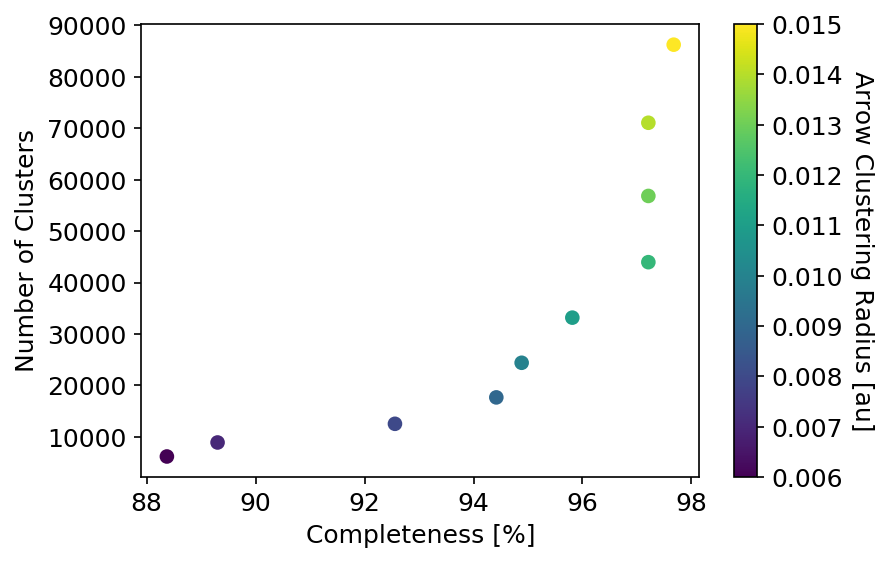

In [45]:
# Number of clusters vs completeness
plt.figure(dpi=150)
plt.scatter(roc[:,1],roc[:,3],c=roc[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Number of Clusters')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

## Rerun HelioLinC3D for different clustering parameters with mean state filtering

In [121]:

def heliolinc_roc(cr_arrow_range=np.arange(0.006,0.016,0.001),cr_obs=0.06,
                  ct_max=1.5/24, ct_min=25/86400, min_samples=3,
                  rall=np.arange(1.8,3.3,0.1),drdtall=np.append(np.arange(-0.01,0.0151,0.002),0),
                  n_cores=10, mean_state_filter_variance_limit=5e-8):
    """ Generate ROC data for HelioLinC3D. 
    
    Parameters:
    -----------
    cr_arrow_range    ... numpy array, Clustering radii for propagated arrows [au]
    cr_obs            ... float, Clustering radius for heliocentric positions projected from observations [au]
    ct_max            ... float, Maximum temporal separation for tracklet observations (days)
    min_samples       ... integer, Minimum number of arrows to be clustered ('DBSCAN only')
    rall              ... numpy array, Range of heliocentric distances searched by HelioLinC [au]
    rrdot             ... numpy array, Range of heliocentric radial velocities searched by HelioLinC [au/day]
    n_cores           ... integer, Number of cores available
    mean_state_filter_variance_limit ... float, Variance limit for mean state filtering 
                          of clusters (positions) [au^2]
                          
    Returns:
    --------
    
    """
    
    results=[]
    
    for cr_arrows in cr_arrow_range:


        # Iterator for joblib based paralellization
        rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

        # How many configuraitons do we have to run in total?
        print("Configurations to run:" len(rrdot)*len(cr_arrow_range))


        n_cores=10

        with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
            clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                              (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                               clustering_algorithm='dbscan', light_time=False, 
                                               verbose=False, n_jobs=1) 
                                               for r, drdt in rrdot ) 

        clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
        clustered_observations['clusterId']=clustered_observations.index

        dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
        #filtering
        cog2=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
        cog2['cluster_Id']=cog2.index

        dfdifi=hl.linkages2difi(cog2,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
        dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
        dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

        (all_truths, findable_observations, summary, 
               all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
               findable_objects, missed_objects) = hl.runDifi(dfobs_difi, cog2, 
                                                              obsIdName='obsId', linkageIdName='cluster_Id',
                                                              objIdName='ObjID', nightName='night', timeName='time',
                                                              findability='tracklet', linkage_min_obs=2, 
                                                              max_obs_separation=1.5/24, 
                                                              min_linkage_nights=3, 
                                                              metric="nightly_linkages")

        results.append([cr_arrows,all_truths, findable_observations, summary, 
               all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
               findable_objects, missed_objects])

HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2: 100%|██████████| 390/390 [03:26<00:00,  1.88it/s]


## Plot the ROC curve after mean state filtering 

In [126]:
roc_f=[]

for r in results_filtered:
    roc_f.append([r[0],r[6].completeness[0],r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id)])

roc_f=np.array(roc_f)

/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


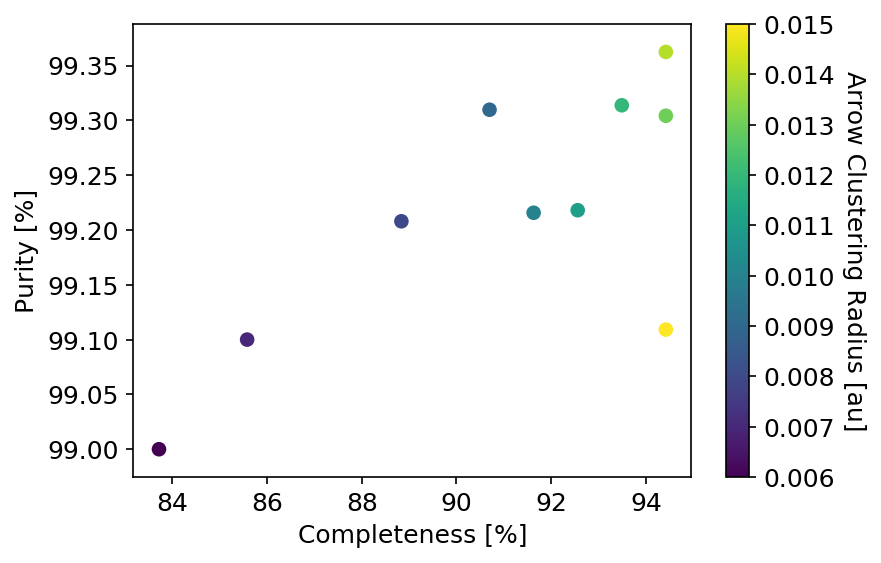

In [127]:
plt.figure(dpi=150)
plt.scatter(roc_f[:,1],roc_f[:,2],c=roc_f[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Purity [%]')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

## The above results are most promising as they show that HelioLinC3D achieves LSST requirements for completeness at a very high purity.

## Create a summary plot.

In [141]:
cr_arrow_range=np.arange(0.002,0.03,0.002)

results_filtered2=[]
variance_limit=5e-8

for cr_arrows in cr_arrow_range:
    # Clustering radius for heliocentric positions projected from observations [au]
    cr_obs=0.06
    # Clustering radius for propagated arrows [au]
    #cr_arrows=0.012
    # max temporal separation for tracklet observations (days)
    ct_max=1.5/24
    # min temporal separation for tracklet observations, e.g. exposure time (days)
    ct_min=25/86400 
    # Minimum number of arrows to be clustered ('DBSCAN only')
    min_samples=3


    # define range of heliocentric distances
    rall=np.arange(1.8,3.3,0.1)

    # define range of heliocentric radial velocities
    drdtall=np.arange(-0.01,0.0152,0.002)
    np.append(drdtall,0.0)

    # Iterator for joblib based paralellization
    rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

    # How many configuraitons do we have to run?
    print(len(rrdot))


    n_cores=10

    with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 

    clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
    clustered_observations['clusterId']=clustered_observations.index

    number_of_clusters=len(clustered_observations.index)
    
    dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
    #filtering
    number_of_deduplicated_clusters=len(dedupe.index)
        
    cog2=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
    cog2['cluster_Id']=cog2.index

    number_of_filtered_clusters=len(cog2.index)
    
    dfdifi=hl.linkages2difi(cog2,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
    dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
    dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

    (all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, cog2, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")
    print(cr_arrows,summary_heliolinc.completeness)
    results_filtered2.append([cr_arrows,all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects,number_of_clusters,number_of_deduplicated_clusters,
                             number_of_filtered_clusters])

HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.002 0    61.395349
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.004 0    77.209302
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.006 0    83.72093
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.008 0    88.837209
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.01 0    91.627907
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.012 0    93.488372
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.014 0    94.418605
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.016 0    94.883721
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.018000000000000002 0    95.348837
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.020000000000000004 0    95.348837
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.022 0    96.744186
Name: completeness, dtype: float64
195


HelioLinC2:   5%|▍         | 9/195 [00:12<06:20,  2.05s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.024 0    96.744186
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.026000000000000002 0    96.27907
Name: completeness, dtype: float64
195


HelioLinC2:   4%|▎         | 7/195 [00:11<25:40,  8.19s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
HelioLinC2: 100%|██████████| 195/195 [01:52<00:00,  1.74it/s]


0.028000000000000004 0    96.27907
Name: completeness, dtype: float64


In [203]:
roc_f2=[]

for r in results_filtered2:
    roc_f2.append([r[0],r[6].completeness[0],
                   r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id),
                   r[9],r[10],r[11],r[6].findable_found+r[6].findable_found ])

roc_f2=np.array(roc_f2)

/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


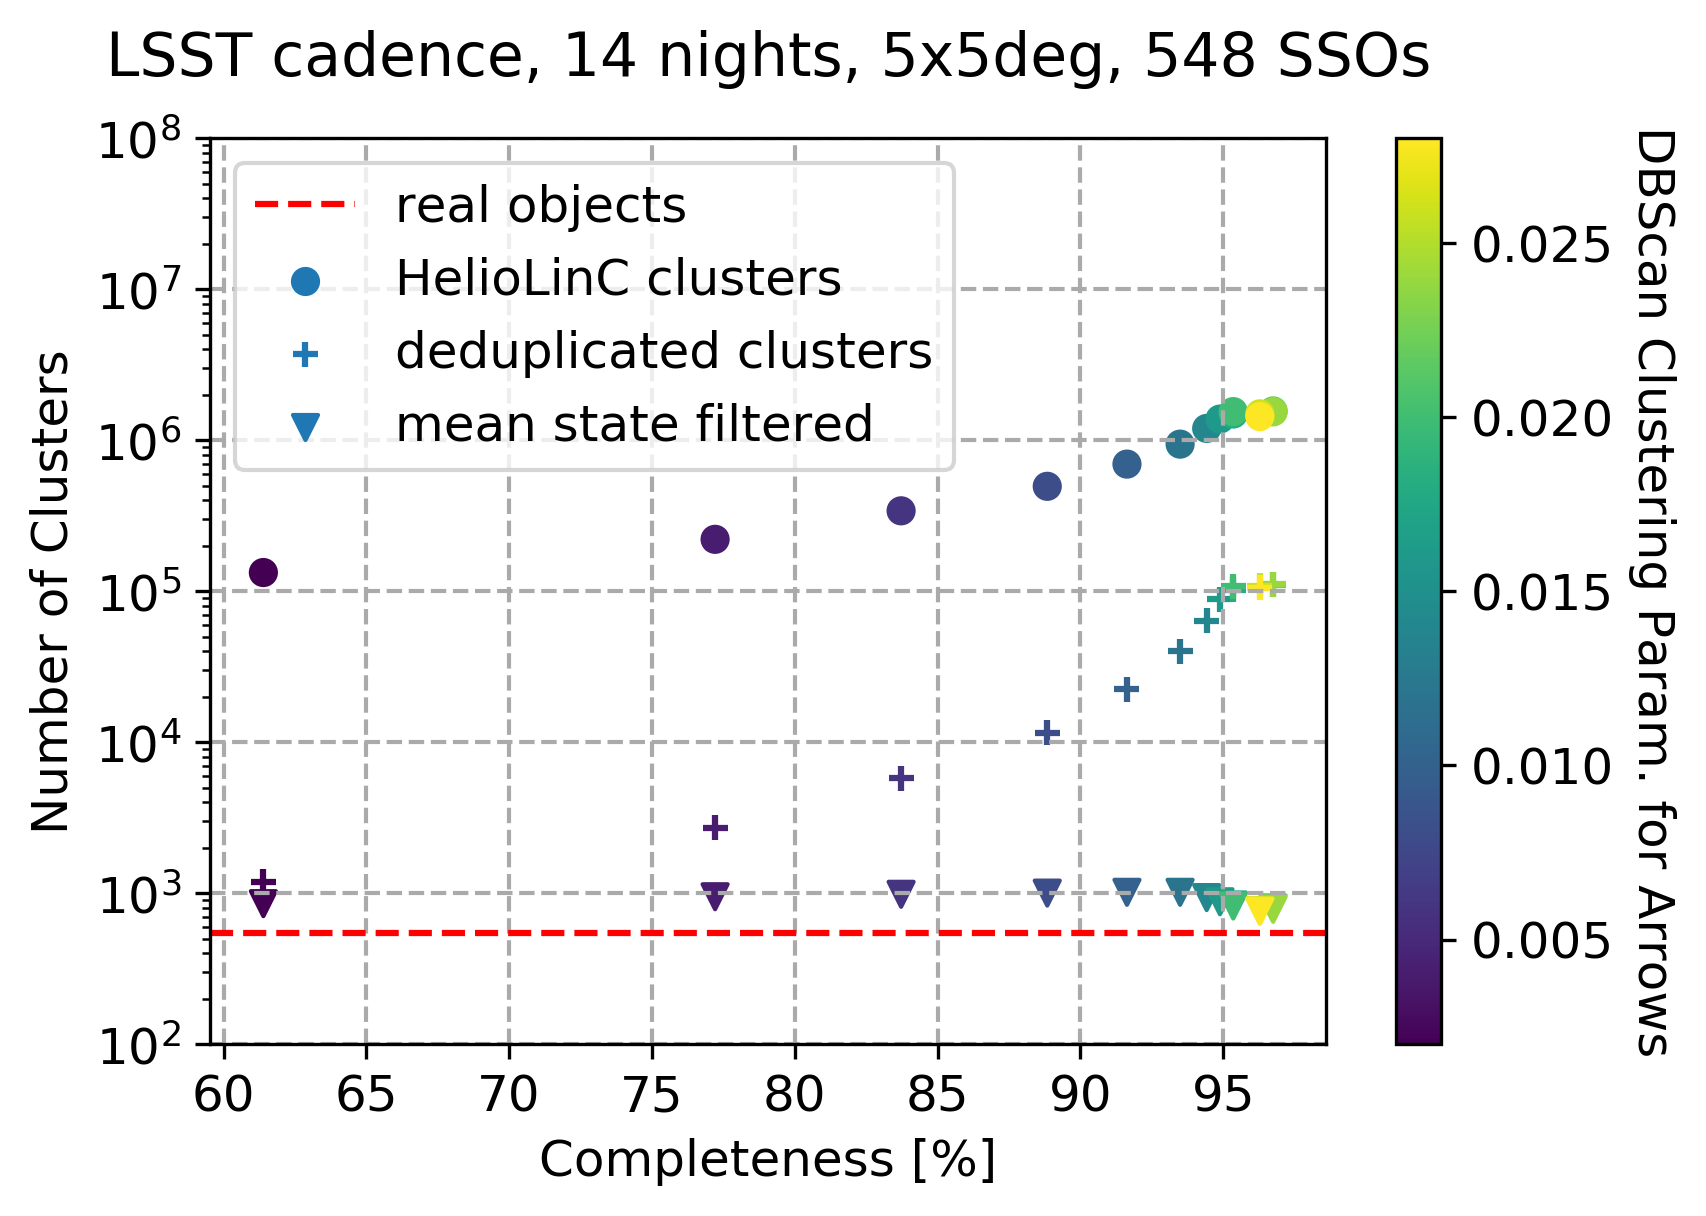

In [227]:
plt.figure(dpi=300)
plt.scatter(roc_f2[:,1],roc_f2[:,4],c=roc_f2[:,0],label='HelioLinC clusters')
plt.scatter(roc_f2[:,1],roc_f2[:,5],c=roc_f2[:,0],label='deduplicated clusters',marker='+')
plt.scatter(roc_f2[:,1],roc_f2[:,3],c=roc_f2[:,0],label='mean state filtered',marker='v')
plt.axhline(y=results_filtered2[0][6].num_members.values, color='r', linestyle='--',label='real objects')
plt.ylim(100,1e8)
plt.xlabel('Completeness [%]')
plt.ylabel('Number of Clusters')
plt.yscale('log')
cbar = plt.colorbar()
cbar.set_label('DBScan Clustering Param. for Arrows', rotation=270, labelpad=15)
plt.xticks(np.arange(60,100,5)) 
plt.grid(color='#AAAAAA', linestyle='--', linewidth=1)
plt.legend(loc='upper left')
plt.title("LSST cadence, 14 nights, 5x5deg, 548 SSOs",pad=15)
plt.show()

# Conclusions

* HelioLinC3D performs at least as good as classical MOPS in terms of finding objects. Currently, it performs best for objects with fewer (~4) observations. 
* Mean state filtering with conservative on sky O-C RMS values allows us to select clusters that are essentially completely free from noise.

